# Mini Project 1

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

**Instructions** Use current stock data to create two potentially profitable investment portfolios. One that is higher risk and one that is lower risk.

-- You are to interpret and explain your interpretation of a high risk profile and low risk profile of a portfolio. You should provide some measurable quantitative data in your explanation.

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# Step 1: Define stock tickers
high_risk_tickers = ['TSLA', 'NVDA', 'PLTR', 'COIN', 'ARKK']
low_risk_tickers = ['JNJ', 'PG', 'KO', 'WMT', 'MCD']
all_tickers = high_risk_tickers + low_risk_tickers

# Step 2: Download adjusted close prices
data = yf.download(all_tickers, start="2024-05-01", end="2025-05-01")
data.describe()

[*********************100%***********************]  10 of 10 completed


Price        Close                                                  \
Ticker        ARKK        COIN         JNJ          KO         MCD   
count   250.000000  250.000000  250.000000  250.000000  250.000000   
mean     50.146840  226.973960  153.183792   65.681639  284.786518   
std       6.924537   46.265246    7.441897    4.014807   21.165200   
min      39.470001  147.350006  140.931885   59.908230  241.541870   
25%      44.959999  191.344997  145.683064   61.992527  265.421402   
50%      47.280001  219.209999  153.595360   64.398678  289.319107   
75%      56.207500  258.752502  159.040619   69.564152  300.190308   
max      67.019997  343.619995  167.699997   73.900002  321.290009   

Price                                                               ...  \
Ticker        NVDA          PG        PLTR        TSLA         WMT  ...   
count   250.000000  250.000000  250.000000  250.000000  250.000000  ...   
mean    122.719598  165.957831   55.516520  271.775320   81.268745  ...   
std      15.133704    4.291179   29.019007   79.131469   11.940033  ...   
min      83.013718  156.622711   20.600000  168.470001   58.050869  ...   
25%     112.359161  162.892956   28.489999  216.157497   69.211756  ...   
50%     123.599091  165.802292   43.540001  249.540001   81.589596  ...   
75%     135.222565  168.671181   79.857500  335.605011   91.690907  ...   
max     149.416245  177.504425  124.620003  479.859985  104.509628  ...   

Price         Volume                                                          \
Ticker          ARKK          COIN           JNJ            KO           MCD   
count   2.500000e+02  2.500000e+02  2.500000e+02  2.500000e+02  2.500000e+02   
mean    9.256796e+06  9.680040e+06  7.920468e+06  1.542247e+07  3.565588e+06   
std     4.506753e+06  4.955886e+06  3.025741e+06  6.408766e+06  1.822884e+06   
min     3.133500e+06  3.241700e+06  3.164100e+06  5.019100e+06  1.433900e+06   
25%     5.983950e+06  6.372275e+06  5.835075e+06  1.113068e+07  2.525575e+06   
50%     8.008200e+06  8.677400e+06  7.256450e+06  1.359265e+07  3.096000e+06   
75%     1.152975e+07  1.128812e+07  9.036975e+06  1.756212e+07  4.044725e+06   
max     2.843250e+07  4.243750e+07  2.330310e+07  4.857850e+07  1.879200e+07   

Price                                                                         
Ticker          NVDA            PG          PLTR          TSLA           WMT  
count   2.500000e+02  2.500000e+02  2.500000e+02  2.500000e+02  2.500000e+02  
mean    3.031140e+08  7.166336e+06  7.486134e+07  9.570666e+07  1.785671e+07  
std     1.194731e+08  3.144076e+06  4.765679e+07  3.789141e+07  8.158724e+06  
min     1.051570e+08  2.460800e+06  1.843380e+07  3.716760e+07  6.287500e+06  
25%     2.210727e+08  5.383400e+06  4.259578e+07  6.751788e+07  1.245592e+07  
50%     2.772812e+08  6.371350e+06  6.253770e+07  8.447765e+07  1.543605e+07  
75%     3.621547e+08  8.110850e+06  9.420332e+07  1.143512e+08  2.069892e+07  
max     8.350650e+08  2.864750e+07  4.502905e+08  2.217073e+08  6.054560e+07  

[8 rows x 50 columns]


📊 Portfolio Performance Summary:
   Portfolio  Annual Return  Annual Volatility  Sharpe Ratio  Max Drawdown
0  High Risk       0.734454           0.528200      1.390485      0.559193
1   Low Risk       0.214767           0.139162      1.543286      0.219280


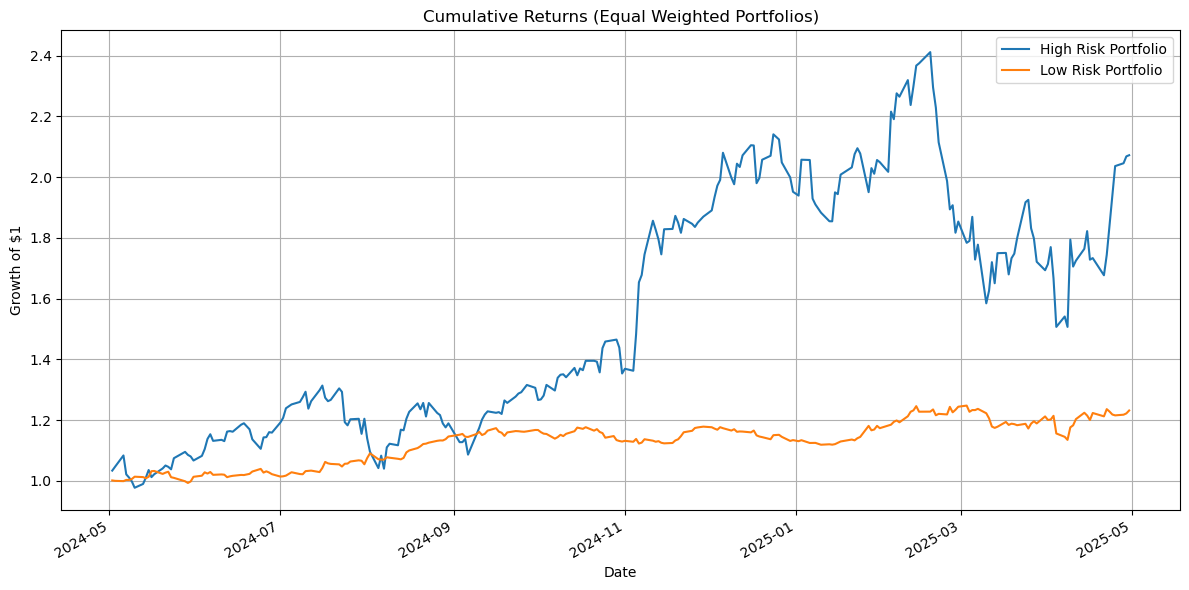

In [4]:
# If columns are multi-level, extract 'Adj Close' properly
if isinstance(data.columns, pd.MultiIndex):
    data = data['Close']
else:
    raise ValueError("Unexpected column structure in downloaded data.")

# Step 3: Compute daily returns
returns = data.pct_change().dropna()
returns_high = returns[high_risk_tickers]
returns_low = returns[low_risk_tickers]

# Step 4: Equal weight portfolio metrics
def portfolio_metrics(returns, name="Portfolio"):
    n_assets = returns.shape[1]
    weights = np.array([1/n_assets] * n_assets)

    mean_returns = returns.mean() * 252
    cov_matrix = returns.cov() * 252

    port_return = np.dot(weights, mean_returns)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe = port_return / port_vol

    cum_returns = (returns + 1).cumprod()
    max_dd = ((cum_returns.cummax() - cum_returns) / cum_returns.cummax()).max().max()

    return {
        "Portfolio": name,
        "Annual Return": port_return,
        "Annual Volatility": port_vol,
        "Sharpe Ratio": sharpe,
        "Max Drawdown": max_dd
    }

# Step 5: Calculate and summarize metrics
metrics_high = portfolio_metrics(returns_high, name="High Risk")
metrics_low = portfolio_metrics(returns_low, name="Low Risk")

summary_df = pd.DataFrame([metrics_high, metrics_low])
print("\n📊 Portfolio Performance Summary:")
print(summary_df)

# Step 6: Plot cumulative returns
plt.figure(figsize=(12, 6))
(returns_high + 1).cumprod().mean(axis=1).plot(label='High Risk Portfolio')
(returns_low + 1).cumprod().mean(axis=1).plot(label='Low Risk Portfolio')
plt.title('Cumulative Returns (Equal Weighted Portfolios)')
plt.xlabel('Date')
plt.ylabel('Growth of $1')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()